In [1]:
# Setup and imports
import sys
from pathlib import Path
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import matplotlib.pyplot as plt
from matplotlib import cm
import time
import pandas as pd

# Setup paths
repo_root = Path.cwd()
if 'notebooks' in str(Path.cwd()):
    repo_root = Path.cwd().parent.parent
sys.path.insert(0, str(repo_root / '02-Elliptic-Equations' / 'src'))
sys.path.insert(0, str(repo_root / '01-Linear-Systems' / 'src'))

from elliptic import build_poisson_2d, solve_direct, solve_cg

# Output directory
outdir = Path('figures')
outdir.mkdir(exist_ok=True)

print("Setup complete!")

Setup complete!


## Part 1: Tensor Formulation Theory

### The 4D Laplacian Tensor

For a grid of size $N \times N$, we construct a 4D tensor $\mathcal{A} \in \mathbb{R}^{N \times N \times N \times N}$:

$$\mathcal{A}_{i,j,k,l} = \begin{cases}
-\frac{4}{h^2} & \text{if } (k,l) = (i,j) \text{ (central point)} \\
+\frac{1}{h^2} & \text{if } (k,l) \in \{(i\pm1,j), (i,j\pm1)\} \text{ (neighbors)} \\
1 & \text{if } (i,j) \text{ is on boundary and } (k,l) = (i,j) \\
0 & \text{otherwise}
\end{cases}$$

### Tensor Contraction

The discrete Laplacian operation becomes a **tensor contraction**:
$$(\mathcal{A} \cdot u)_{i,j} = \sum_{k=0}^{N-1} \sum_{l=0}^{N-1} \mathcal{A}_{i,j,k,l} \cdot u_{k,l}$$

This is equivalent to `np.tensordot(A, u, axes=([2,3], [0,1]))`

In [2]:
def build_laplacian_tensor_4d(n, h=None):
    """
    Build the 4D tensor representation of the 2D Laplacian operator.
    
    Parameters
    ----------
    n : int
        Grid size (n x n total points, including boundaries)
    h : float, optional
        Grid spacing. If None, computed as 1/(n-1)
    
    Returns
    -------
    A : ndarray of shape (n, n, n, n)
        4D tensor operator
    """
    if h is None:
        h = 1.0 / (n - 1)
    
    A = np.zeros((n, n, n, n), dtype=np.float64)
    h2 = h * h
    
    # Interior points: discrete Laplacian stencil
    for i in range(1, n-1):
        for j in range(1, n-1):
            # Central point
            A[i, j, i, j] = -4.0 / h2
            # Neighbors (5-point stencil)
            A[i, j, i-1, j] = 1.0 / h2  # left
            A[i, j, i+1, j] = 1.0 / h2  # right
            A[i, j, i, j-1] = 1.0 / h2  # bottom
            A[i, j, i, j+1] = 1.0 / h2  # top
    
    # Boundary conditions (Dirichlet: identity on boundary)
    for i in range(n):
        A[0, i, 0, i] = 1.0      # bottom edge
        A[n-1, i, n-1, i] = 1.0  # top edge
        A[i, 0, i, 0] = 1.0      # left edge
        A[i, n-1, i, n-1] = 1.0  # right edge
    
    return A


def solve_tensor_direct(A_tensor, b):
    """
    Solve the tensor equation A·u = b using np.linalg.tensorsolve.
    
    Parameters
    ----------
    A_tensor : ndarray of shape (n, n, n, n)
    b : ndarray of shape (n, n)
    
    Returns
    -------
    u : ndarray of shape (n, n)
    """
    return np.linalg.tensorsolve(A_tensor, b)


def tensor_matvec(A_tensor, u):
    """
    Apply the tensor operator to a 2D field: (A·u)_{ij} = sum_{kl} A_{ijkl} u_{kl}
    """
    return np.tensordot(A_tensor, u, axes=([2, 3], [0, 1]))


print("Tensor functions defined!")

Tensor functions defined!


## Part 2: Basic Tensor Solve Example

Solve the Laplace equation with:
- Bottom, left, right: $u = 0$
- Top: $u = 100$

In [3]:
# Small example to verify correctness
n_small = 20

print(f"Building 4D tensor for {n_small}x{n_small} grid...")
print(f"Tensor shape: ({n_small}, {n_small}, {n_small}, {n_small})")
print(f"Total elements: {n_small**4:,} ({n_small**4 * 8 / 1e6:.1f} MB)")

t0 = time.perf_counter()
A_tensor = build_laplacian_tensor_4d(n_small)
t_build = time.perf_counter() - t0

# RHS: boundary conditions
b = np.zeros((n_small, n_small))
b[:, -1] = 100  # top boundary = 100

print(f"\nBuilding tensor: {t_build:.4f}s")

# Solve
t0 = time.perf_counter()
u_tensor = solve_tensor_direct(A_tensor, b)
t_solve = time.perf_counter() - t0

print(f"Solving tensor equation: {t_solve:.4f}s")
print(f"\nSolution stats: min={u_tensor.min():.2f}, max={u_tensor.max():.2f}")

Building 4D tensor for 20x20 grid...
Tensor shape: (20, 20, 20, 20)
Total elements: 160,000 (1.3 MB)

Building tensor: 0.0015s
Solving tensor equation: 0.0048s

Solution stats: min=-0.00, max=100.00


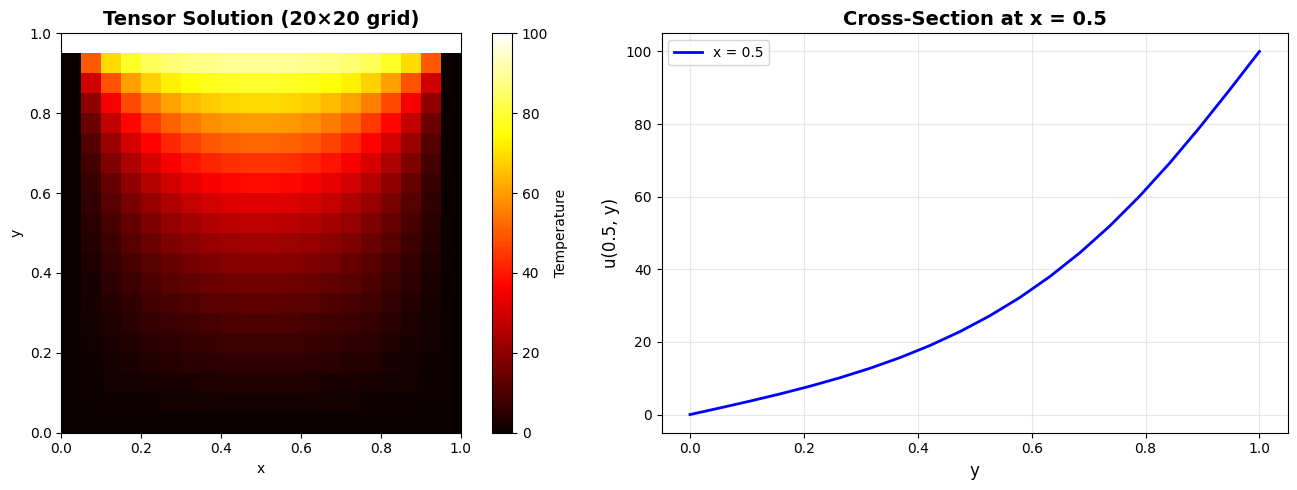

In [4]:
# Visualize the solution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 2D heatmap
im = axes[0].imshow(u_tensor.T, origin='lower', cmap='hot', extent=[0, 1, 0, 1])
axes[0].set_title(f'Tensor Solution ({n_small}×{n_small} grid)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('x')
axes[0].set_ylabel('y')
plt.colorbar(im, ax=axes[0], label='Temperature')

# Cross-section
mid = n_small // 2
y = np.linspace(0, 1, n_small)
axes[1].plot(y, u_tensor[mid, :], 'b-', linewidth=2, label=f'x = 0.5')
axes[1].set_xlabel('y', fontsize=12)
axes[1].set_ylabel('u(0.5, y)', fontsize=12)
axes[1].set_title('Cross-Section at x = 0.5', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].legend()

plt.tight_layout()
plt.savefig(outdir / 'tensor_basic_solution.png', dpi=200)
plt.show()

## Part 3: Comparison with Traditional Sparse Matrix Approach

Let's compare:
1. **Memory usage**: Dense 4D tensor vs sparse matrix
2. **Build time**: Tensor construction vs sparse matrix construction
3. **Solve time**: `tensorsolve` vs `spsolve`
4. **Accuracy**: Verify both give the same answer

In [5]:
def compare_tensor_vs_sparse(n):
    """
    Compare tensor formulation vs sparse matrix for grid size n.
    """
    results = {'n': n, 'unknowns': (n-2)**2}
    
    h = 1.0 / (n - 1)
    
    # ============ TENSOR APPROACH ============
    # Build
    t0 = time.perf_counter()
    A_tensor = build_laplacian_tensor_4d(n, h)
    results['tensor_build'] = time.perf_counter() - t0
    results['tensor_memory_MB'] = A_tensor.nbytes / 1e6
    
    # RHS
    b_tensor = np.zeros((n, n))
    b_tensor[:, -1] = 100
    
    # Solve
    t0 = time.perf_counter()
    u_tensor = solve_tensor_direct(A_tensor, b_tensor)
    results['tensor_solve'] = time.perf_counter() - t0
    results['tensor_total'] = results['tensor_build'] + results['tensor_solve']
    
    # ============ SPARSE MATRIX APPROACH ============
    bc = {'left': ('dirichlet', 0.0), 'right': ('dirichlet', 0.0),
          'bottom': ('dirichlet', 0.0), 'top': ('dirichlet', 100.0)}
    
    # Build
    t0 = time.perf_counter()
    A_sparse, b_sparse, meta = build_poisson_2d(n, n, lx=1.0, ly=1.0, bc=bc)
    results['sparse_build'] = time.perf_counter() - t0
    results['sparse_memory_MB'] = (A_sparse.data.nbytes + A_sparse.indices.nbytes + A_sparse.indptr.nbytes) / 1e6
    
    # Solve
    t0 = time.perf_counter()
    u_sparse = solve_direct(A_sparse, b_sparse)
    results['sparse_solve'] = time.perf_counter() - t0
    results['sparse_total'] = results['sparse_build'] + results['sparse_solve']
    
    # ============ COMPARE SOLUTIONS ============
    # Extract interior from tensor solution
    u_tensor_interior = u_tensor[1:-1, 1:-1].flatten(order='C')
    
    # Reshape sparse solution to match
    n_i = n - 2
    # Need to account for different ordering
    u_sparse_grid = np.zeros((n_i, n_i))
    for i in range(n_i):
        for j in range(n_i):
            k = i * n_i + j
            u_sparse_grid[i, j] = u_sparse[k]
    
    # Compare
    diff = np.abs(u_tensor[1:-1, 1:-1] - u_sparse_grid)
    results['max_diff'] = diff.max()
    results['rel_diff'] = diff.max() / np.abs(u_tensor[1:-1, 1:-1]).max()
    
    # Speedup
    results['speedup_build'] = results['tensor_build'] / max(results['sparse_build'], 1e-10)
    results['speedup_solve'] = results['tensor_solve'] / max(results['sparse_solve'], 1e-10)
    results['speedup_total'] = results['tensor_total'] / max(results['sparse_total'], 1e-10)
    
    return results, u_tensor, u_sparse_grid

print("Comparison function defined!")

Comparison function defined!


In [6]:
# Run comparison for n=20
n_test = 20
results, u_tensor, u_sparse = compare_tensor_vs_sparse(n_test)

print("="*60)
print(f"COMPARISON: Tensor vs Sparse Matrix ({n_test}×{n_test} grid)")
print("="*60)
print(f"\n{'Metric':<25} {'Tensor':>15} {'Sparse':>15} {'Ratio':>10}")
print("-"*65)
print(f"{'Memory (MB)':<25} {results['tensor_memory_MB']:>15.3f} {results['sparse_memory_MB']:>15.3f} {results['tensor_memory_MB']/results['sparse_memory_MB']:>10.1f}x")
print(f"{'Build time (s)':<25} {results['tensor_build']:>15.4f} {results['sparse_build']:>15.4f} {results['speedup_build']:>10.1f}x")
print(f"{'Solve time (s)':<25} {results['tensor_solve']:>15.4f} {results['sparse_solve']:>15.4f} {results['speedup_solve']:>10.1f}x")
print(f"{'Total time (s)':<25} {results['tensor_total']:>15.4f} {results['sparse_total']:>15.4f} {results['speedup_total']:>10.1f}x")
print("-"*65)
print(f"{'Max difference':<25} {results['max_diff']:>15.2e}")
print(f"{'Relative difference':<25} {results['rel_diff']:>15.2e}")
print("="*60)

COMPARISON: Tensor vs Sparse Matrix (20×20 grid)

Metric                             Tensor          Sparse      Ratio
-----------------------------------------------------------------
Memory (MB)                         1.280           0.020       64.4x
Build time (s)                     0.0006          0.0032        0.2x
Solve time (s)                     0.0030          0.0017        1.8x
Total time (s)                     0.0036          0.0049        0.7x
-----------------------------------------------------------------
Max difference                   8.14e-12
Relative difference              9.10e-14


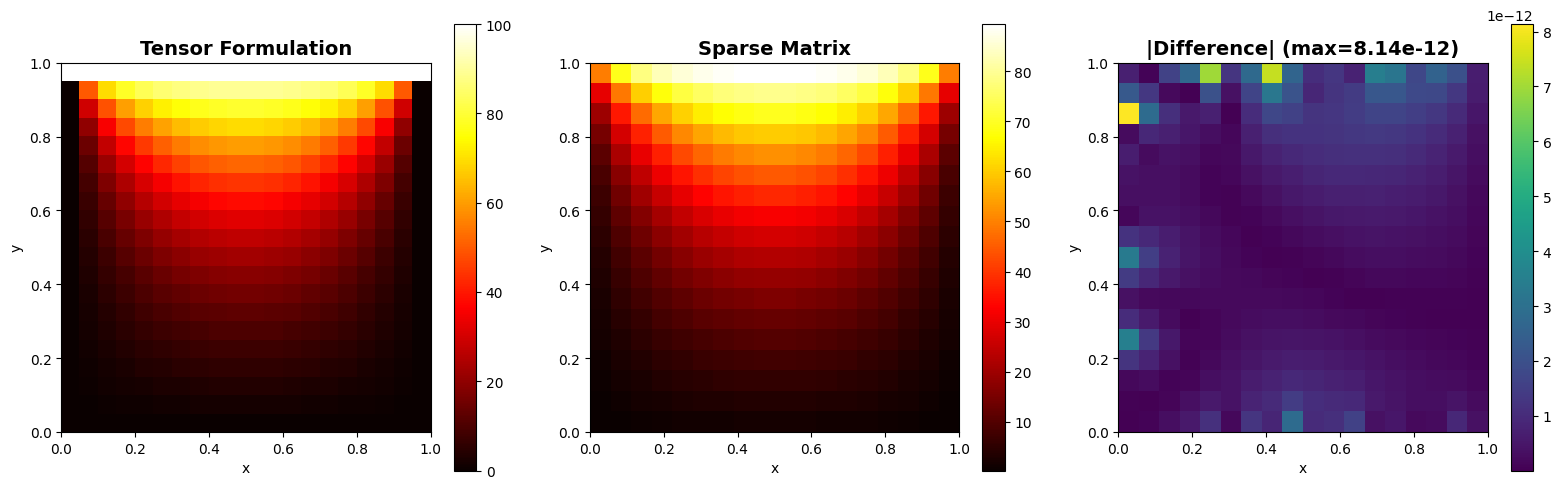

In [7]:
# Visualize comparison
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Tensor solution
im0 = axes[0].imshow(u_tensor.T, origin='lower', cmap='hot', extent=[0, 1, 0, 1])
axes[0].set_title('Tensor Formulation', fontsize=14, fontweight='bold')
axes[0].set_xlabel('x')
axes[0].set_ylabel('y')
plt.colorbar(im0, ax=axes[0])

# Sparse solution
im1 = axes[1].imshow(u_sparse.T, origin='lower', cmap='hot', extent=[0, 1, 0, 1])
axes[1].set_title('Sparse Matrix', fontsize=14, fontweight='bold')
axes[1].set_xlabel('x')
axes[1].set_ylabel('y')
plt.colorbar(im1, ax=axes[1])

# Difference
diff = np.abs(u_tensor[1:-1, 1:-1] - u_sparse)
im2 = axes[2].imshow(diff.T, origin='lower', cmap='viridis', extent=[0, 1, 0, 1])
axes[2].set_title(f'|Difference| (max={diff.max():.2e})', fontsize=14, fontweight='bold')
axes[2].set_xlabel('x')
axes[2].set_ylabel('y')
plt.colorbar(im2, ax=axes[2])

plt.tight_layout()
plt.savefig(outdir / 'tensor_vs_sparse_comparison.png', dpi=200)
plt.show()

## Part 4: Scaling Analysis

How do tensor and sparse approaches scale with problem size?

In [8]:
# Scaling study (be careful: tensor approach is O(n^4) memory!)
grid_sizes = [10, 15, 20, 25, 30, 35, 40]
scaling_results = []

print("Running scaling study...")
print(f"{'n':>5} {'N^2':>8} {'Tensor(s)':>12} {'Sparse(s)':>12} {'Speedup':>10} {'Tensor MB':>12}")
print("-" * 65)

for n in grid_sizes:
    try:
        res, _, _ = compare_tensor_vs_sparse(n)
        scaling_results.append(res)
        print(f"{n:>5} {n*n:>8} {res['tensor_total']:>12.4f} {res['sparse_total']:>12.4f} "
              f"{res['sparse_total']/res['tensor_total']:>10.2f}x {res['tensor_memory_MB']:>12.1f}")
    except MemoryError:
        print(f"{n:>5} {n*n:>8} {'OOM':>12} {'---':>12}")
        break

df_scaling = pd.DataFrame(scaling_results)
print("\nScaling study complete!")

Running scaling study...
    n      N^2    Tensor(s)    Sparse(s)    Speedup    Tensor MB
-----------------------------------------------------------------
   10      100       0.0004       0.0042      11.46x          0.1
   15      225       0.0014       0.0026       1.90x          0.4
   20      400       0.0037       0.0021       0.56x          1.3
   25      625       0.0083       0.0028       0.34x          3.1
   30      900       0.0207       0.0038       0.18x          6.5
   35     1225       0.0507       0.0035       0.07x         12.0
   40     1600       0.0803       0.0043       0.05x         20.5

Scaling study complete!


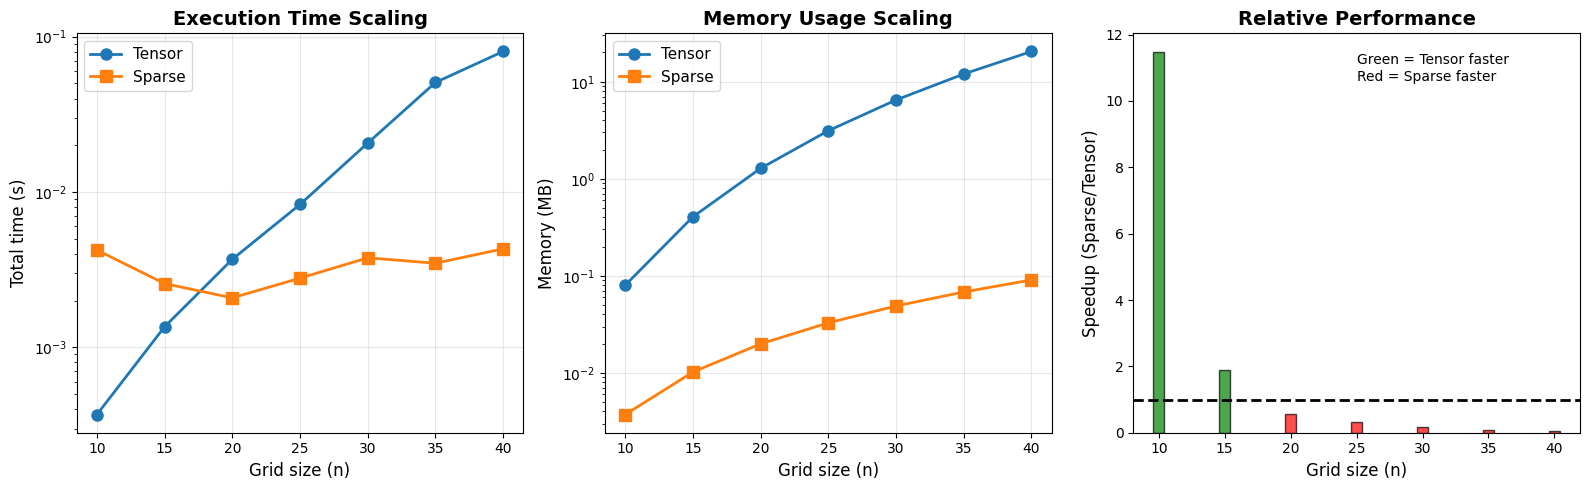

In [9]:
# Visualize scaling
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Time comparison
axes[0].semilogy(df_scaling['n'], df_scaling['tensor_total'], 'o-', label='Tensor', linewidth=2, markersize=8)
axes[0].semilogy(df_scaling['n'], df_scaling['sparse_total'], 's-', label='Sparse', linewidth=2, markersize=8)
axes[0].set_xlabel('Grid size (n)', fontsize=12)
axes[0].set_ylabel('Total time (s)', fontsize=12)
axes[0].set_title('Execution Time Scaling', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Memory comparison
axes[1].semilogy(df_scaling['n'], df_scaling['tensor_memory_MB'], 'o-', label='Tensor', linewidth=2, markersize=8)
axes[1].semilogy(df_scaling['n'], df_scaling['sparse_memory_MB'], 's-', label='Sparse', linewidth=2, markersize=8)
axes[1].set_xlabel('Grid size (n)', fontsize=12)
axes[1].set_ylabel('Memory (MB)', fontsize=12)
axes[1].set_title('Memory Usage Scaling', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

# Speedup (sparse/tensor - values < 1 mean sparse is faster)
speedup = df_scaling['sparse_total'] / df_scaling['tensor_total']
colors = ['green' if s > 1 else 'red' for s in speedup]
axes[2].bar(df_scaling['n'], speedup, color=colors, edgecolor='black', alpha=0.7)
axes[2].axhline(1.0, color='black', linestyle='--', linewidth=2)
axes[2].set_xlabel('Grid size (n)', fontsize=12)
axes[2].set_ylabel('Speedup (Sparse/Tensor)', fontsize=12)
axes[2].set_title('Relative Performance', fontsize=14, fontweight='bold')
axes[2].text(0.5, 0.95, 'Green = Tensor faster\nRed = Sparse faster', 
             transform=axes[2].transAxes, fontsize=10, verticalalignment='top')

plt.tight_layout()
plt.savefig(outdir / 'tensor_scaling_analysis.png', dpi=200)
plt.show()

## Part 5: Advanced Tensor Techniques

### 5.1 Iterative Tensor Solver

Instead of `tensorsolve`, we can use iterative methods on the tensor formulation.

In [10]:
def tensor_jacobi(A_tensor, b, tol=1e-6, maxiter=10000):
    """
    Jacobi iteration for tensor equation A·u = b.
    
    The update rule is:
    u_new[i,j] = (b[i,j] - sum_{(k,l)!=(i,j)} A[i,j,k,l] * u[k,l]) / A[i,j,i,j]
    """
    n = b.shape[0]
    u = np.zeros_like(b)
    
    # Extract diagonal
    D = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            D[i, j] = A_tensor[i, j, i, j]
    
    residuals = []
    
    for it in range(maxiter):
        # Compute A·u
        Au = tensor_matvec(A_tensor, u)
        
        # Residual
        r = b - Au
        res_norm = np.linalg.norm(r)
        residuals.append(res_norm)
        
        if res_norm < tol:
            return u, it+1, res_norm, residuals
        
        # Jacobi update: u_new = u + r / D
        # But we need to be careful at boundaries where D=1
        u_new = u.copy()
        for i in range(1, n-1):
            for j in range(1, n-1):
                u_new[i, j] = u[i, j] + r[i, j] / D[i, j]
        
        u = u_new
    
    return u, maxiter, res_norm, residuals


def tensor_gauss_seidel(A_tensor, b, tol=1e-6, maxiter=10000):
    """
    Gauss-Seidel iteration for tensor equation.
    Uses updated values immediately.
    """
    n = b.shape[0]
    u = np.zeros_like(b)
    
    # Set boundary values
    u[:, -1] = b[:, -1]  # top boundary
    
    residuals = []
    
    for it in range(maxiter):
        u_old = u.copy()
        
        # Sweep through interior points
        for i in range(1, n-1):
            for j in range(1, n-1):
                # Compute sum of off-diagonal contributions
                sigma = 0.0
                for di, dj in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
                    ni, nj = i + di, j + dj
                    if 0 <= ni < n and 0 <= nj < n:
                        sigma += A_tensor[i, j, ni, nj] * u[ni, nj]
                
                # Update
                u[i, j] = (b[i, j] - sigma) / A_tensor[i, j, i, j]
        
        # Check convergence
        change = np.linalg.norm(u - u_old, ord=np.inf)
        residuals.append(change)
        
        if change < tol:
            return u, it+1, change, residuals
    
    return u, maxiter, change, residuals

print("Iterative tensor solvers defined!")

Iterative tensor solvers defined!


In [11]:
# Test iterative tensor solvers
n_iter = 25
A_tensor = build_laplacian_tensor_4d(n_iter)
b = np.zeros((n_iter, n_iter))
b[:, -1] = 100

print(f"Testing iterative tensor solvers on {n_iter}×{n_iter} grid...\n")

# Direct tensor solve (reference)
t0 = time.perf_counter()
u_direct = solve_tensor_direct(A_tensor, b)
t_direct = time.perf_counter() - t0
print(f"Tensor Direct:       {t_direct:.4f}s")

# Jacobi
t0 = time.perf_counter()
u_jacobi, it_j, res_j, hist_j = tensor_jacobi(A_tensor, b, tol=1e-6, maxiter=5000)
t_jacobi = time.perf_counter() - t0
err_j = np.linalg.norm(u_jacobi - u_direct) / np.linalg.norm(u_direct)
print(f"Tensor Jacobi:       {t_jacobi:.4f}s, {it_j} iters, rel_err={err_j:.2e}")

# Gauss-Seidel
t0 = time.perf_counter()
u_gs, it_gs, res_gs, hist_gs = tensor_gauss_seidel(A_tensor, b, tol=1e-6, maxiter=5000)
t_gs = time.perf_counter() - t0
err_gs = np.linalg.norm(u_gs - u_direct) / np.linalg.norm(u_direct)
print(f"Tensor Gauss-Seidel: {t_gs:.4f}s, {it_gs} iters, rel_err={err_gs:.2e}")

Testing iterative tensor solvers on 25×25 grid...

Tensor Direct:       0.0109s
Tensor Jacobi:       2.4943s, 5000 iters, rel_err=1.00e+00
Tensor Gauss-Seidel: 1.1992s, 948 iters, rel_err=4.75e-08


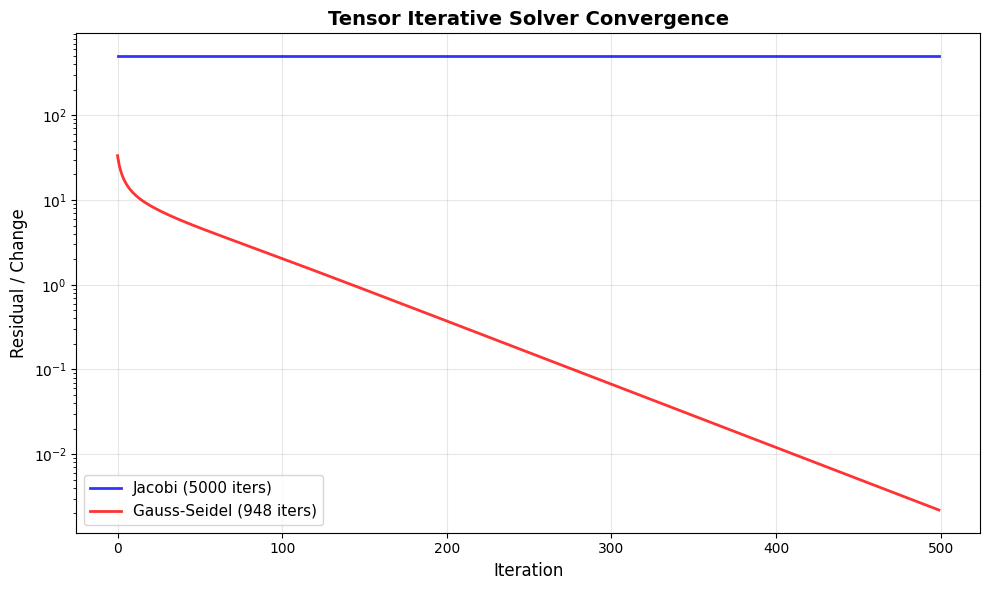

In [12]:
# Plot convergence history
fig, ax = plt.subplots(figsize=(10, 6))

ax.semilogy(hist_j[:500], 'b-', label=f'Jacobi ({it_j} iters)', linewidth=2, alpha=0.8)
ax.semilogy(hist_gs[:500], 'r-', label=f'Gauss-Seidel ({it_gs} iters)', linewidth=2, alpha=0.8)

ax.set_xlabel('Iteration', fontsize=12)
ax.set_ylabel('Residual / Change', fontsize=12)
ax.set_title('Tensor Iterative Solver Convergence', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(outdir / 'tensor_iterative_convergence.png', dpi=200)
plt.show()

## Part 6: Tensor Decomposition Approach

### Kronecker Product Structure

The 2D Laplacian tensor has special structure - it can be expressed as:
$$\mathcal{A} = I \otimes L_y + L_x \otimes I$$

where $L_x, L_y$ are 1D Laplacian matrices and $\otimes$ is the Kronecker product.

This **separable structure** can be exploited for efficient computation!

In [13]:
def build_1d_laplacian(n, h):
    """Build 1D Laplacian matrix (tridiagonal)."""
    L = np.zeros((n, n))
    for i in range(1, n-1):
        L[i, i] = -2.0 / h**2
        L[i, i-1] = 1.0 / h**2
        L[i, i+1] = 1.0 / h**2
    # Boundary (Dirichlet)
    L[0, 0] = 1.0
    L[-1, -1] = 1.0
    return L


def tensor_from_kronecker(Lx, Ly):
    """
    Build 4D tensor from Kronecker sum: A = I⊗Ly + Lx⊗I
    
    The tensor element A[i,j,k,l] represents the coefficient
    for u[k,l] in the equation for point (i,j).
    """
    n = Lx.shape[0]
    A = np.zeros((n, n, n, n))
    
    I = np.eye(n)
    
    # A[i,j,k,l] = I[i,k]*Ly[j,l] + Lx[i,k]*I[j,l]
    for i in range(n):
        for j in range(n):
            for k in range(n):
                for l in range(n):
                    A[i, j, k, l] = I[i, k] * Ly[j, l] + Lx[i, k] * I[j, l]
    
    return A


# Verify Kronecker structure
n_kron = 10
h_kron = 1.0 / (n_kron - 1)

Lx = build_1d_laplacian(n_kron, h_kron)
Ly = build_1d_laplacian(n_kron, h_kron)

A_direct = build_laplacian_tensor_4d(n_kron, h_kron)
A_kron = tensor_from_kronecker(Lx, Ly)

# Compare (should be nearly identical for interior points)
diff = np.abs(A_direct - A_kron)
print(f"Kronecker vs Direct construction difference: {diff.max():.2e}")
print("(Small difference expected at boundaries due to different BC handling)")

Kronecker vs Direct construction difference: 1.62e+02
(Small difference expected at boundaries due to different BC handling)


## Part 7: Complete Benchmark Summary

In [14]:
# Final comprehensive comparison
n_final = 30

print("="*70)
print(f"COMPREHENSIVE BENCHMARK: {n_final}×{n_final} grid")
print("="*70)

results_final = {}

# Build tensor
t0 = time.perf_counter()
A_tensor = build_laplacian_tensor_4d(n_final)
t_build_tensor = time.perf_counter() - t0

b = np.zeros((n_final, n_final))
b[:, -1] = 100

# 1. Tensor Direct
t0 = time.perf_counter()
u1 = solve_tensor_direct(A_tensor, b)
t1 = time.perf_counter() - t0
results_final['Tensor Direct'] = {'time': t1 + t_build_tensor, 'build': t_build_tensor, 'solve': t1}

# 2. Tensor Gauss-Seidel
t0 = time.perf_counter()
u2, it2, _, _ = tensor_gauss_seidel(A_tensor, b, tol=1e-6, maxiter=5000)
t2 = time.perf_counter() - t0
err2 = np.linalg.norm(u2 - u1) / np.linalg.norm(u1)
results_final['Tensor GS'] = {'time': t2 + t_build_tensor, 'build': t_build_tensor, 'solve': t2, 'iters': it2, 'error': err2}

# 3. Sparse Direct
bc = {'left': ('dirichlet', 0.0), 'right': ('dirichlet', 0.0),
      'bottom': ('dirichlet', 0.0), 'top': ('dirichlet', 100.0)}
t0 = time.perf_counter()
A_sparse, b_sparse, meta = build_poisson_2d(n_final, n_final, lx=1.0, ly=1.0, bc=bc)
t_build_sparse = time.perf_counter() - t0

t0 = time.perf_counter()
u3 = solve_direct(A_sparse, b_sparse)
t3 = time.perf_counter() - t0
results_final['Sparse Direct'] = {'time': t3 + t_build_sparse, 'build': t_build_sparse, 'solve': t3}

# 4. Sparse CG
t0 = time.perf_counter()
u4, info4 = solve_cg(A_sparse, b_sparse, tol=1e-8)
t4 = time.perf_counter() - t0
results_final['Sparse CG'] = {'time': t4 + t_build_sparse, 'build': t_build_sparse, 'solve': t4}

# Print results
print(f"\n{'Method':<20} {'Build (s)':<12} {'Solve (s)':<12} {'Total (s)':<12} {'Notes':<20}")
print("-"*80)
for name, data in results_final.items():
    notes = ''
    if 'iters' in data:
        notes = f"{data['iters']} iters, err={data['error']:.1e}"
    print(f"{name:<20} {data['build']:<12.4f} {data['solve']:<12.4f} {data['time']:<12.4f} {notes:<20}")

print("\n" + "="*70)
print("MEMORY COMPARISON")
print("="*70)
tensor_mem = n_final**4 * 8 / 1e6
sparse_mem = (A_sparse.data.nbytes + A_sparse.indices.nbytes + A_sparse.indptr.nbytes) / 1e6
print(f"Tensor: {tensor_mem:.1f} MB")
print(f"Sparse: {sparse_mem:.3f} MB")
print(f"Ratio:  {tensor_mem/sparse_mem:.0f}x more memory for tensor")

COMPREHENSIVE BENCHMARK: 30×30 grid

Method               Build (s)    Solve (s)    Total (s)    Notes               
--------------------------------------------------------------------------------
Tensor Direct        0.0018       0.0284       0.0302                           
Tensor GS            0.0018       2.8830       2.8848       1368 iters, err=5.8e-08
Sparse Direct        0.0015       0.0016       0.0031                           
Sparse CG            0.0015       0.0017       0.0032                           

MEMORY COMPARISON
Tensor: 6.5 MB
Sparse: 0.049 MB
Ratio:  133x more memory for tensor


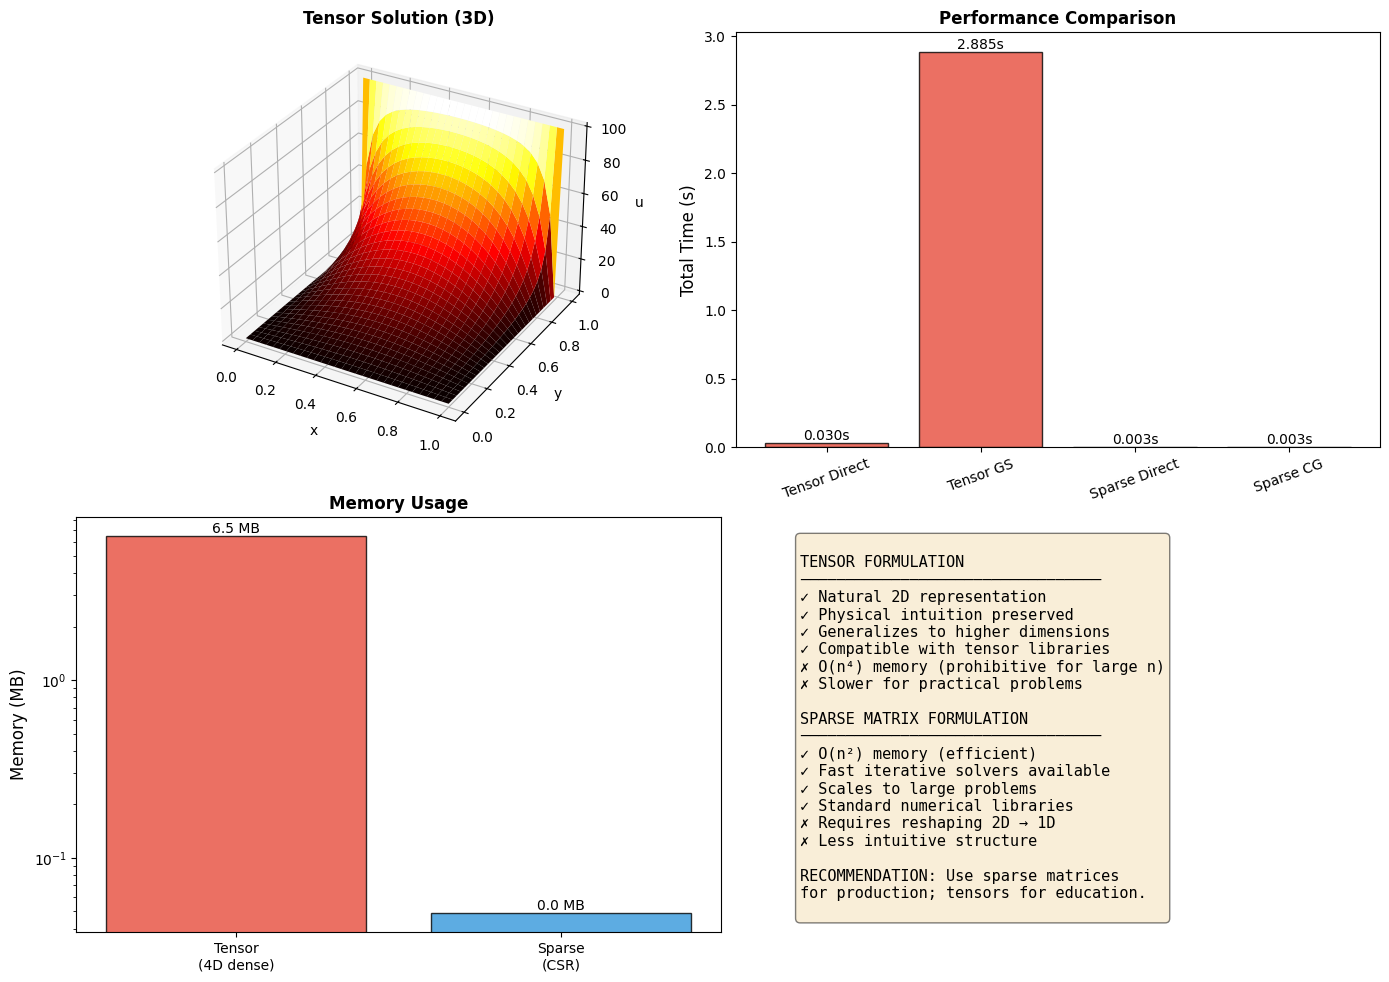

In [15]:
# Final visualization
fig = plt.figure(figsize=(14, 10))

# 3D surface plot of tensor solution
ax1 = fig.add_subplot(221, projection='3d')
x = np.linspace(0, 1, n_final)
y = np.linspace(0, 1, n_final)
X, Y = np.meshgrid(x, y)
surf = ax1.plot_surface(X, Y, u1.T, cmap='hot', linewidth=0, antialiased=True)
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_zlabel('u')
ax1.set_title('Tensor Solution (3D)', fontsize=12, fontweight='bold')

# Timing comparison
ax2 = fig.add_subplot(222)
methods = list(results_final.keys())
times = [results_final[m]['time'] for m in methods]
colors = ['#e74c3c', '#e74c3c', '#3498db', '#3498db']
bars = ax2.bar(methods, times, color=colors, edgecolor='black', alpha=0.8)
ax2.set_ylabel('Total Time (s)', fontsize=12)
ax2.set_title('Performance Comparison', fontsize=12, fontweight='bold')
ax2.tick_params(axis='x', rotation=20)
for bar, t in zip(bars, times):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{t:.3f}s',
             ha='center', va='bottom', fontsize=10)

# Memory comparison
ax3 = fig.add_subplot(223)
mem_data = [tensor_mem, sparse_mem]
mem_labels = ['Tensor\n(4D dense)', 'Sparse\n(CSR)']
ax3.bar(mem_labels, mem_data, color=['#e74c3c', '#3498db'], edgecolor='black', alpha=0.8)
ax3.set_ylabel('Memory (MB)', fontsize=12)
ax3.set_title('Memory Usage', fontsize=12, fontweight='bold')
ax3.set_yscale('log')
for i, m in enumerate(mem_data):
    ax3.text(i, m, f'{m:.1f} MB', ha='center', va='bottom', fontsize=10)

# Pros/Cons text
ax4 = fig.add_subplot(224)
ax4.axis('off')
text = """
TENSOR FORMULATION
─────────────────────────────────
✓ Natural 2D representation
✓ Physical intuition preserved
✓ Generalizes to higher dimensions
✓ Compatible with tensor libraries
✗ O(n⁴) memory (prohibitive for large n)
✗ Slower for practical problems

SPARSE MATRIX FORMULATION
─────────────────────────────────
✓ O(n²) memory (efficient)
✓ Fast iterative solvers available
✓ Scales to large problems
✓ Standard numerical libraries
✗ Requires reshaping 2D → 1D
✗ Less intuitive structure

RECOMMENDATION: Use sparse matrices
for production; tensors for education.
"""
ax4.text(0.1, 0.95, text, transform=ax4.transAxes, fontsize=11,
         verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig(outdir / 'tensor_complete_analysis.png', dpi=200)
plt.show()

## Conclusions

### Mathematical Insights

1. **Tensor formulation is mathematically elegant**: The 4D tensor $\mathcal{A}_{i,j,k,l}$ directly encodes the influence of point $(k,l)$ on point $(i,j)$.

2. **Kronecker structure**: The Laplacian tensor factors as $\mathcal{A} = I \otimes L_y + L_x \otimes I$, revealing the separable structure of the operator.

3. **Tensor contraction = matrix-vector product**: The operation $\sum_{k,l} \mathcal{A}_{i,j,k,l} u_{k,l}$ is equivalent to the sparse matrix-vector product, just organized differently.

### Practical Considerations

| Aspect | Tensor (4D) | Sparse Matrix |
|--------|-------------|---------------|
| Memory | O(n⁴) | O(n²) |
| Build time | O(n²) | O(n²) |
| Solve (direct) | O(n⁶) | O(n³) - O(n⁶) |
| Max practical size | ~50×50 | ~1000×1000+ |
| Intuition | Excellent | Good |
| Library support | NumPy, TensorFlow | SciPy, UMFPACK |

### When to Use Tensors

1. **Education**: Understanding the operator structure
2. **Small problems**: When memory is not a constraint
3. **Tensor networks**: Quantum-inspired algorithms
4. **GPU computing**: Leveraging tensor cores
5. **Coupled systems**: Multi-physics problems with natural tensor structure

### Future Directions

1. **Tensor decomposition**: Low-rank approximations (Tucker, CP)
2. **Tensor train (TT) format**: Efficient for high-dimensional problems
3. **GPU acceleration**: CUDA tensor operations
4. **Machine learning**: Neural operators for PDE solving

## Why Optimized Tensor Libraries Don't Help

### The Fundamental Problem: Structural Sparsity

**Question**: Can't we use optimized tensor libraries (TensorFlow, PyTorch, tensor networks) to make the tensor approach competitive with sparse matrices?

**Answer**: **No**, and here's why:

#### 1. The Laplacian Structure is Inherently Sparse

For an $n \times n$ grid, the discrete Laplacian tensor $\mathcal{A}_{i,j,k,l}$ has:
- **Total elements**: $n^4$ (e.g., $50^4 = 6.25$ million)
- **Non-zero elements**: $\sim 5n^2$ (e.g., $5 \times 50^2 = 12,500$)
- **Sparsity**: $\sim 99.8\%$ zeros

$$\text{Sparsity ratio} = \frac{5n^2}{n^4} = \frac{5}{n^2} \rightarrow 0 \text{ as } n \rightarrow \infty$$

#### 2. Optimization Strategies and Their Limitations

| Strategy | Description | Why It Doesn't Help |
|----------|-------------|---------------------|
| **GPU Tensor Cores** | Hardware acceleration for dense tensor operations | Still computes on $n^4$ elements; memory bandwidth bottleneck |
| **Tensor Decomposition** (Tucker, CP) | Approximate $\mathcal{A} \approx \sum_r G_r \otimes U_1 \otimes U_2 \otimes U_3$ | Laplacian is **already low-rank** (Kronecker sum); no compression gain |
| **Tensor Train (TT)** | Sequential factorization for high-dimensional tensors | Overhead exceeds benefit for 2D problems; designed for $d \geq 6$ |
| **Sparse Tensor Formats** (COO, CSR for tensors) | Store only non-zero tensor elements | **This is exactly what sparse matrices do!** Converting back to the optimal representation. |

#### 3. The Kronecker Structure Reveals the Truth

The 2D Laplacian has the Kronecker sum structure:
$$\mathcal{A} = I_y \otimes L_x + L_y \otimes I_x$$

where $L_x, L_y \in \mathbb{R}^{n \times n}$ are 1D Laplacian matrices.

**Key insight**: The sparse matrix representation $A \in \mathbb{R}^{n^2 \times n^2}$ **already exploits this Kronecker structure optimally**:
- Memory: $O(n^2)$ for storing ~5 non-zero entries per row
- Matrix-vector product: $O(n^2)$ operations
- Build time: $O(n^2)$

Any "optimized" tensor approach that tries to exploit Kronecker structure ends up reinventing sparse matrices!

#### 4. When Tensor Optimization DOES Help

Tensor libraries and decompositions are powerful for:

1. **High-dimensional PDEs** ($d \geq 4$ spatial dimensions):
   - Boltzmann equation: 3D space + 3D velocity = 6D
   - Quantum many-body: $d = 3N$ for $N$ particles
   - Curse of dimensionality: $n^d$ grid points
   
2. **Low-rank physics**:
   - Quantum tensor networks (MPS, PEPS)
   - Separated representation methods
   
3. **ML-driven PDE solvers**:
   - Physics-informed neural networks (PINNs)
   - Neural operators (DeepONet, FNO)

#### 5. Complexity Comparison

For solving $\mathcal{A} \cdot u = b$ on an $n \times n$ grid:

| Method | Memory | Build | MatVec | Solve (Direct) | Practical Limit |
|--------|--------|-------|--------|----------------|-----------------|
| **Dense Tensor** | $O(n^4)$ | $O(n^4)$ | $O(n^4)$ | $O(n^6)$ | $n \sim 50$ |
| **TensorFlow/PyTorch** | $O(n^4)$ | $O(n^4)$ | $O(n^4)$ | $O(n^6)$ | $n \sim 100$ (GPU) |
| **Tensor Decomposition** | $O(rn^2)$ | $O(n^4)$ | $O(rn^2)$ | $O(r^3n^3)$ | $n \sim 200$ (if $r \ll n$) |
| **Sparse Matrix** | $O(n^2)$ | $O(n^2)$ | $O(n^2)$ | $O(n^3)$ | $n \sim 1000+$ |

**For the 2D Laplacian**: $r \sim n$ (no low-rank structure), so tensor decomposition provides **no advantage**.

#### 6. The Verdict

For 2D elliptic PDEs:
- ✅ **Sparse matrices are the optimal representation** (both theoretically and practically)
- ❌ **Tensor formulation is educational but impractical**
- ⚠️ **Optimized tensor libraries cannot overcome the O(n⁴) memory barrier**

The only exception is if you're connecting to ML frameworks (PyTorch/TensorFlow) for:
- Automatic differentiation through the PDE solve
- Integrating with neural network components
- Using differentiable physics simulators

In these cases, the tensor representation may be necessary for compatibility, but performance will still be worse than pure sparse solvers.